### Generate sample paths of a McKean-Vlasov SDE using PyTorch

Consider McKean-Vlasov SDE of the following form:

$$ 
\textrm{d}X_t = (\alpha \, X_t + \beta \, \mathbb{E}[X_t]) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad X_0 = x_0.
$$

We approximate the solution $X_t, t \in [0,T]$ by using the following 

$$ 
\textrm{d}X_t = \bigl(\alpha \, X_t + \beta \, \sum^M_{i=1} \gamma_i \mathbf{1}_{[t_{i-1},t_i[}(t) \bigr) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad X_0 = x_0,
$$

where we approximate $\mathbb{E}[X_t]$ for $t \in [t_{i-1},t_i[$ by a single constant $\gamma_i.$ Set $t_0 = 0$ and $t_M = T.$


In [1]:
import torch
import random
from torch import optim, nn
import math
import matplotlib.pyplot as plt
from torchviz import make_dot

import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\aa261w\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class MKVSDElinear_approx(torch.nn.Module):
    def __init__(self, gamma):
        super().__init__()
        # wrap gamma with nn.Parameter to compute gradients with respect to it using autograd
        self.gamma = nn.Parameter(gamma)
    def forward(self, x0, alpha, beta, sigma, M, dt, dW):
        X = x0 * torch.ones(M + 1)
        for i in range(1, M + 1):
            X[i] = X[i - 1] * (1 + alpha * dt) + beta * dt * self.gamma[i - 1] + sigma * dW[i - 1]
        return X
#     def getgradpath(self, x0, alpha, beta, sigma, M, dt):
#         xi = torch.zeros(M, M + 1) # N paths with M gradient values based on size of gamma, and M + 1 values
#         for j in range(M):
#             for i in range(1,M + 1):
#                 if (i == j):
#                     xi[j, i] = xi[j, i - 1] * (1 + alpha * dt) + beta * dt
#                 elif (i != j):
#                     xi[j, i] = xi[j, i - 1] * (1 + alpha * dt)
#         return xi

# seed initialise
torch.manual_seed(42)

# model parameters
M = 100  # number of discretisation steps
x0 = 1
sigma = 1
alpha = - 0.5
beta = 0.3
T = 0.2
dt = T / M

# simulate Brownian increments
dW = dt ** 0.5 * torch.randn(M)
# generate random values for gamma initialisation
gamma = torch.randn(M, requires_grad = True, dtype=torch.float, device=device)

MKVSDE_Xapprox = MKVSDElinear_approx(gamma).to(device)
MKVSDE_Xapproxpath = MKVSDE_Xapprox(x0, alpha, beta, sigma, M, dt, dW)
#MKVSDE_Xapprox_gradpath = MKVSDE_Xapprox.getgradpath(x0, alpha, beta, sigma, M, dt)

#print(MKVSDE_Xapproxpath.size())
#print(MKVSDE_Xapprox_gradpath)
# MKVSDE_Xapproxpath.backward(torch.ones_like(gamma))

In [6]:
torch.manual_seed(42)
n_iteration = 50000
lr = 0.01

model = MKVSDElinear_approx(gamma)
#model = model.to(device)
#print(model.state_dict())

loss_fn = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.SGD(model.parameters(),lr = lr, weight_decay = 0.0001)

i = 0
gamma_aver = 0

while i < n_iteration:
    
    model.train()
    dW = dt ** 0.5 * torch.randn(M)
    path_pred = model(x0, alpha, beta, sigma, M, dt, dW)
    final_loss = loss_fn(path_pred[1:], model.gamma)
    
    final_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    error = torch.abs(path_pred[1:] - model.gamma).detach().numpy()
    
    #print("No. of iteration: %i" % i)
    #print(f"Estimated path: {path_pred}")
    # print(f"Error in call price: {error}")
    gamma_iter = model.state_dict().get('gamma').numpy()
#     print(f'gamma iter is {gamma_iter}')
#     print(f'{model.state_dict()}')
    gamma_aver = gamma_aver * i / (i + 1) + gamma_iter * 1 / (i + 1)
    i += 1
    
print(model.state_dict())

print(gamma_aver)

KeyboardInterrupt: 

Gamma with algorithm is 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.].

Gamma benchmark is 
[1.         0.99960008 0.99920032 0.99880072 0.99840128 0.998002
 0.99760288 0.99720392 0.99680511 0.99640647 0.99600799 0.99560967
 0.9952115  0.9948135  0.99441565 0.99401796 0.99362044 0.99322307
 0.99282586 0.99242881 0.99203191 0.99163518 0.99123861 0.99084219
 0.99044593 0.99004983 0.98965389 0.98925811 0.98886249 0.98846702
 0.98807171 0.98767656 0.98728157 0.98688674 0.98649206 0.98609754
 0.98570318 0.98530898 0.98491494 0.98452105 0.98412732 0.98373375
 0.98334033 0.98294708 0.98255398 0.98216103 0.98176825 0.98137562
 0.98098315 0.98059083 0.98019867 0.97980667 0.97941483 0.97902314
 0.97863161 0.97824024 0.97784902 0.9774579

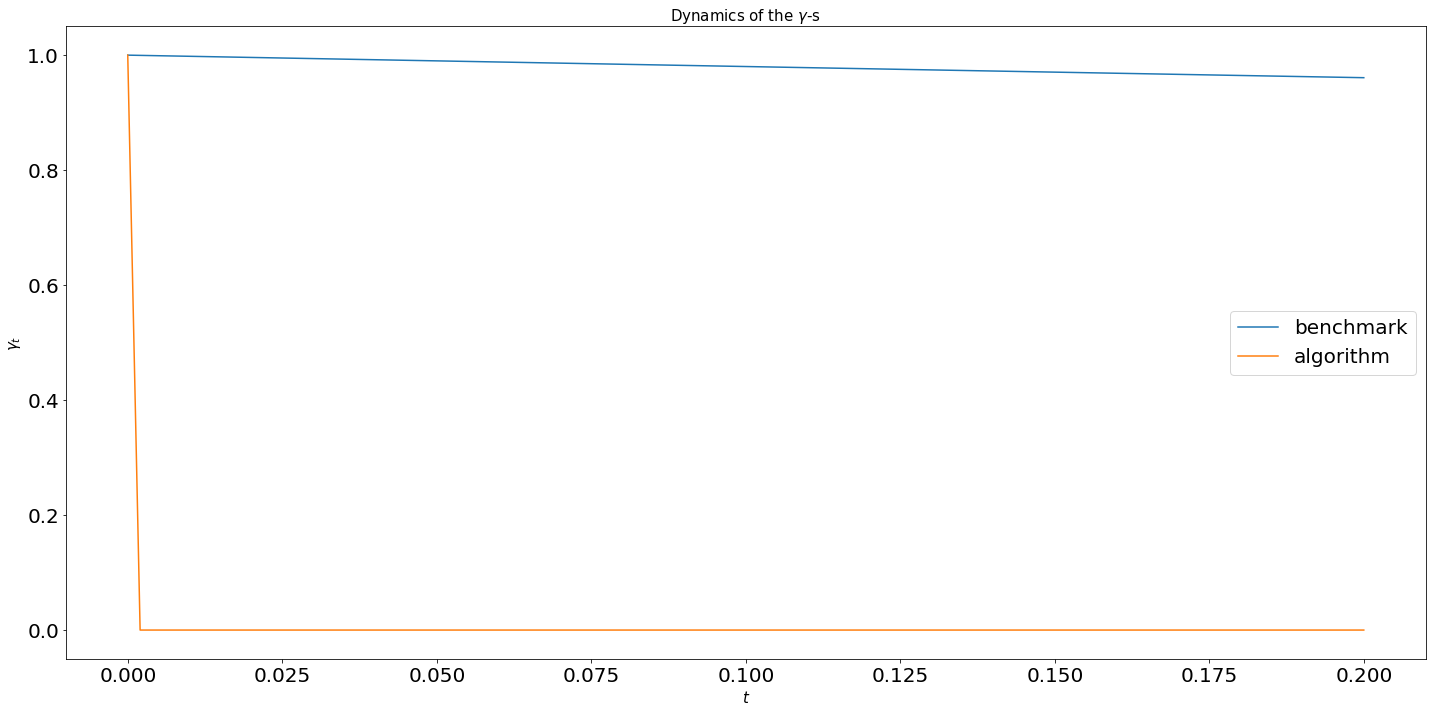

In [5]:
np.insert(gamma_aver, 0, x0)
gamma_aver_2 = np.zeros(M + 1)
gamma_aver_2[0] = x0
gamma_aver_2[1:] = gamma_aver 

#print(gamma_aver_2)

t_benchmark = np.linspace(0,T,M + 1)

t_sgd = np.linspace(0,T,M+1)

gamma_benchmark = np.exp((alpha + beta) * t_benchmark)

print(f'Gamma with algorithm is \n{gamma_aver_2}.\n')

print(f'Gamma benchmark is \n{gamma_benchmark}.\n')

fig, ax = plt.subplots(1, 1, figsize = (20, 10), tight_layout=True)

ax.set_title(r"Dynamics of the $\gamma$-s", fontsize = 15)
ax.set_xlabel(r'$t$',fontsize = 15)
ax.set_ylabel(r'$\gamma_t$',fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 20)
ax.tick_params(axis='both', which='minor', labelsize = 20)

ax.plot(t_benchmark, gamma_benchmark, label = 'benchmark')
ax.plot(t_sgd, gamma_aver_2, label = 'algorithm')

ax.legend(loc = 'best', fontsize = 20)